In [1]:
# Dependencies
from datetime import date
from kiwis_pie import KIWIS
import geopandas as gp

In [2]:
# Make initial connection using base API address
k = KIWIS('https://timeseries.sepa.org.uk/KiWIS/KiWIS')

In [3]:
file_location = 'forth_catchment.geojson'
rio = gp.read_file(file_location)

<AxesSubplot:>

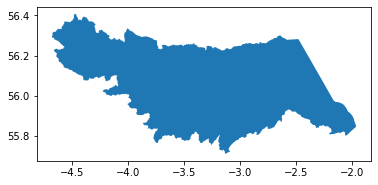

In [4]:
rio.plot()

In [6]:
# List of SEPA stations
station_list = k.get_station_list()
# get rid of stations without lat lon
station_list = station_list.loc[station_list['station_latitude'] != '',]

# Turn stations into geopandas data frame
station_list = gp.GeoDataFrame(
    station_list, geometry=gp.points_from_xy(station_list.station_longitude, station_list.station_latitude))
station_list = station_list.set_crs(epsg=4326)

In [7]:
# Spatially join with region of interest using a point in polygon 
rio_stations = gp.sjoin(station_list,rio)
# Drop nuisance columns
rio_stations = rio_stations.drop(columns=['index_right','fid'])

<AxesSubplot:>

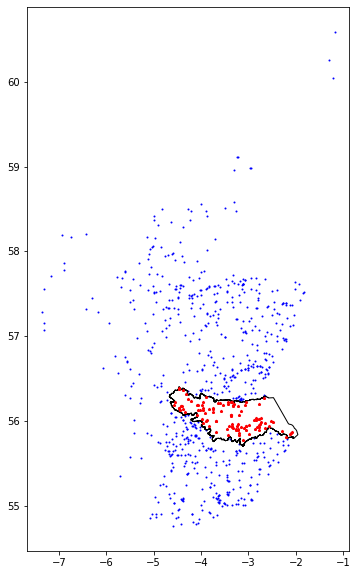

In [24]:
# Plot
base = station_list.plot(marker='o', color='blue', markersize=1,figsize=(10,10))
base = rio.plot(ax=base, color='#ffffff00', edgecolor='black')
rio_stations.plot(ax=base, marker='*', color='red', markersize=6)

In [9]:
# station parameters 'Flow', 'Rain', 'Level'
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values)


In [10]:
# List all relevant parameters
parameters_list['stationparameter_name'].unique().tolist()

['Level', 'Flow', 'Rain', 'GroundwaterLevel', 'TidalLevel']

In [16]:
# We are interested in just water level for this exercise so return only those results
parameters_list = k.get_parameter_list(station_id = rio_stations.station_id.values,stationparameter_name='Level')
parameters_list.head()


,station_name,station_no,station_id,parametertype_id,parametertype_name,stationparameter_name
0,Kirkton Burn,116005,35952,560,S,Level
1,Lower Monachyle,116006,35956,560,S,Level
2,Upper Monachyle,116007,35960,560,S,Level
3,Luffness,14865,36390,560,S,Level
4,Craigiehall,14867,36396,560,S,Level


In [17]:
# Fifty parameters matching water level data for all the stations in the Forth
parameters_list.shape[0]

50

In [15]:
# Select only station data for relevant ids within the forth
rio_stations_par = rio_stations.loc[rio_stations['station_id'].isin(parameters_list['station_id'])]

<AxesSubplot:>

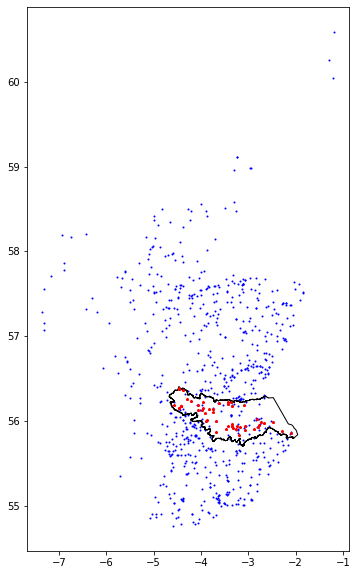

In [23]:
# PLot again
base = station_list.plot(marker='o', color='blue', markersize=1,figsize=(10,10))
base = rio.plot(ax=base, color='#ffffff00', edgecolor='black')
rio_stations_par.plot(ax=base, marker='*', color='red', markersize=6)

In [80]:
# 50 stations returned
rio_stations_par.shape[0]

50

In [25]:
# Check out the different time series interval options for a specific station parameter names
time_series_options = k.get_timeseries_list(station_id = rio_stations_par.station_id,stationparameter_name='Level')['ts_name'].unique().tolist()
time_series_options

['HydrologicalYear.Mean',
 'Month.Max',
 'CalendarYear.Max',
 'Month.Mean',
 'CalendarYear.Min',
 'HydrologicalYear.Max',
 'HydrologicalYear.Min',
 'LongTermValue.Month.Max',
 'LongTermValue.Month.Mean',
 'CalendarYear.Mean',
 'Month.Min',
 'Day.Min',
 'LongTermValue.Month.Min',
 'Day.Mean',
 '15minute',
 'Day.Max',
 'PeaksOverThreshold']

In [29]:
# Look at the documentation for defining returned column headers https://kiwis-pie.readthedocs.io/en/latest/api/kiwis_pie.html#module-kiwis_pie.kiwis
headers=['station_name','station_no','station_id','ts_id','ts_name','parametertype_id','parametertype_name','stationparameter_name','stationparameter_longname','ts_density','ts_unitname','ts_unitsymbol','coverage']

# return ts ids for stations, parameters and time series interval options selected
ts_frame = k.get_timeseries_list(station_id = rio_stations_par.station_id, stationparameter_name='Level',ts_name='Day.Mean',return_fields=headers)

In [32]:
# Just to check there are 50 time series datasets available for the stations, parameters and time series interval options selected
ts_frame.shape[0]

50

In [30]:
# Also check out the temporal coverage and ts_density to inform next query
ts_frame.head(2)

,station_name,station_no,station_id,ts_id,ts_name,parametertype_id,parametertype_name,stationparameter_name,stationparameter_longname,ts_density,ts_unitname,ts_unitsymbol,from,to
0,Callander,14911,36532,54803010,Day.Mean,560,S,Level,River Stage,365,meter,m,1970-06-25T09:00:00.000Z,2022-04-13T09:00:00.000Z
1,Nungate,14909,36528,54787010,Day.Mean,560,S,Level,River Stage,365,meter,m,1994-01-01T09:00:00.000Z,2022-04-13T09:00:00.000Z


In [33]:
# Using Callander as demonstrator return ts_id of interest
ts_of_interest = ts_frame.loc[ts_frame['station_name'] == 'Callander']['ts_id'].values[0]

# Re
timeseries_dataset = k.get_timeseries_values(ts_id = ts_of_interest, to = date(2022,1,31), **{'from': date(2018,1,1)})

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'River Water level (m)')]

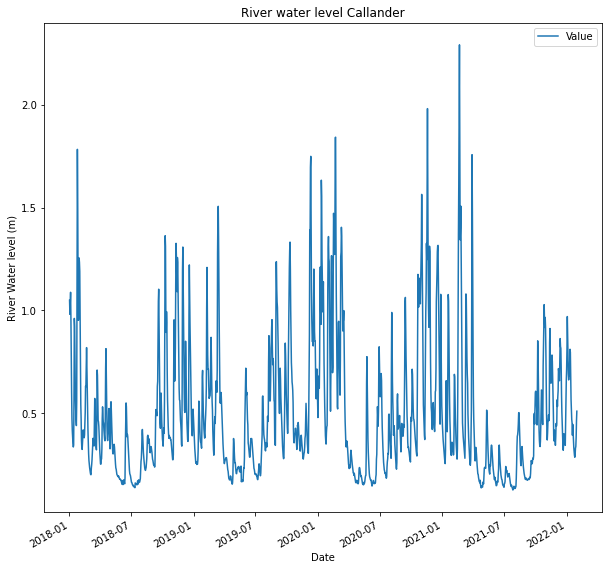

In [38]:
# Plot data - you can automate the addition of labels from metadata  
ax = timeseries_dataset.plot(title='River water level Callander',figsize=(10,10))
ax.set(xlabel="Date", ylabel="River Water level (m)")
